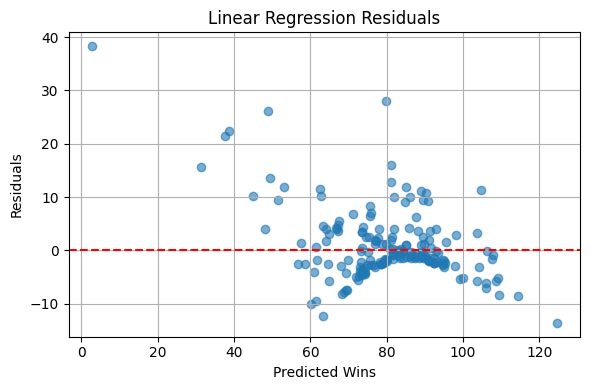

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.21198e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


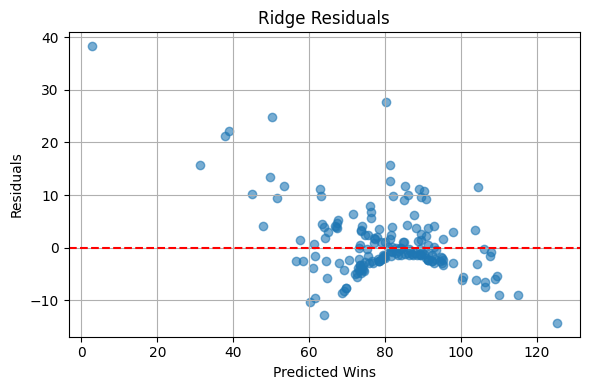

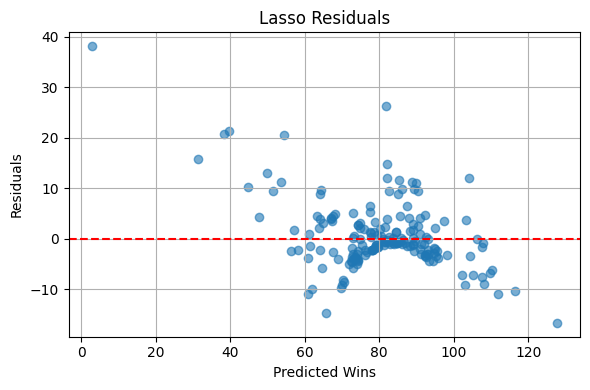

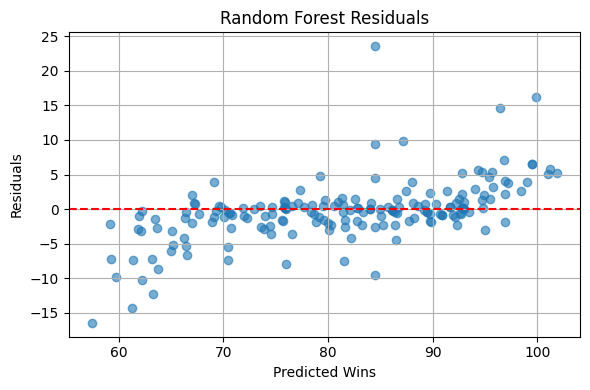


Test Set Performance Summary:
               Model        R2       MAE      RMSE       MBE
3      Random Forest  0.900694  2.745722  4.442859  0.290722
2              Lasso  0.762645  4.553874  6.868675 -0.580714
1              Ridge  0.761228  4.510516  6.889154 -0.853713
0  Linear Regression  0.759587  4.505545  6.912781 -0.933171


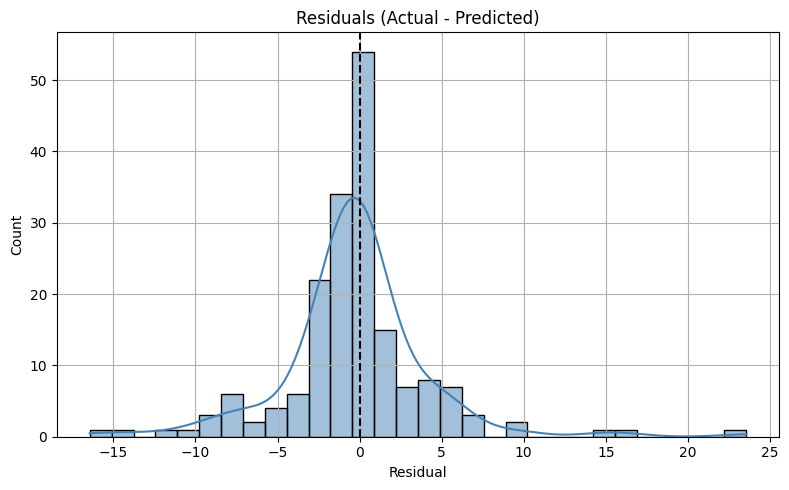

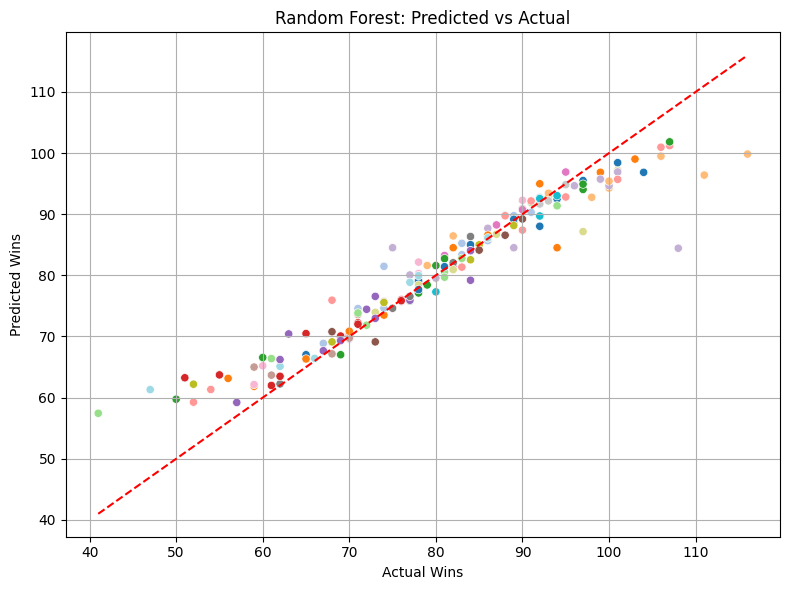

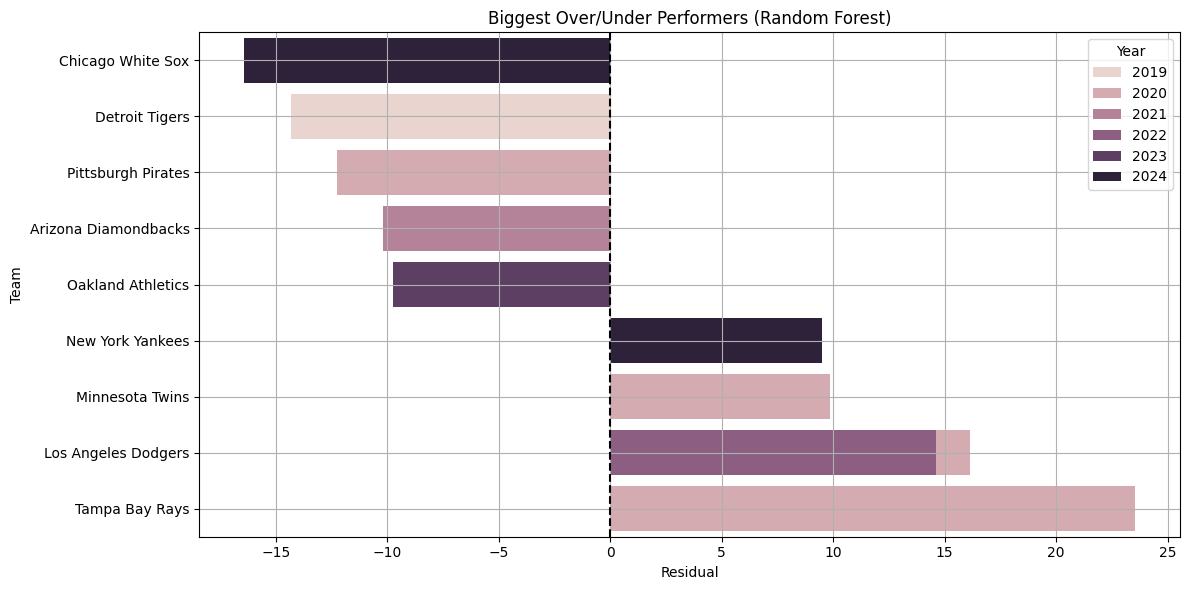

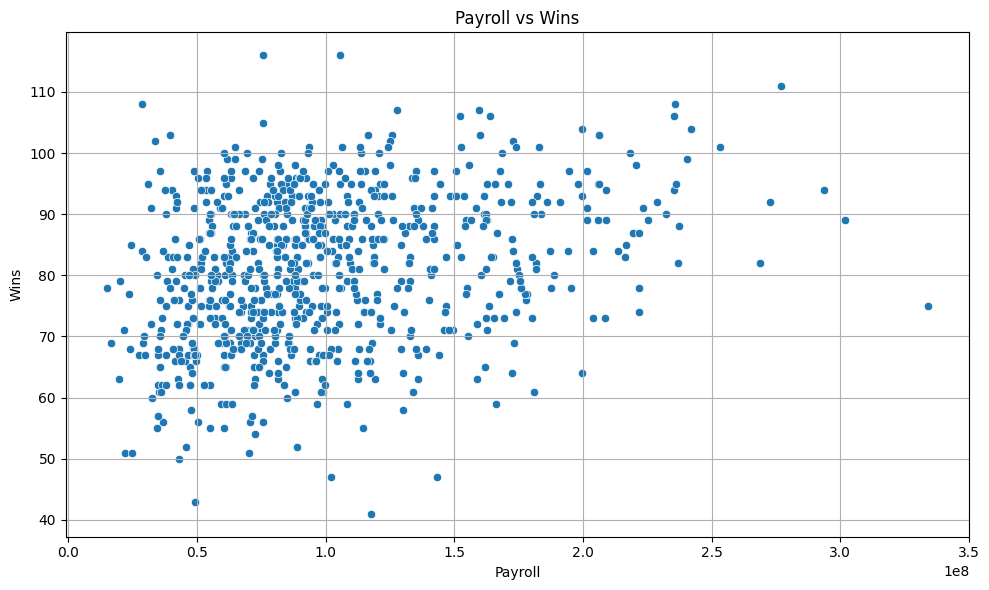

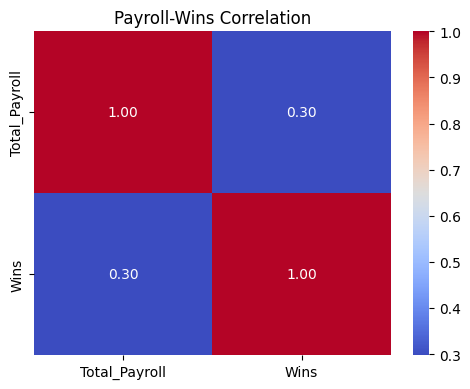

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


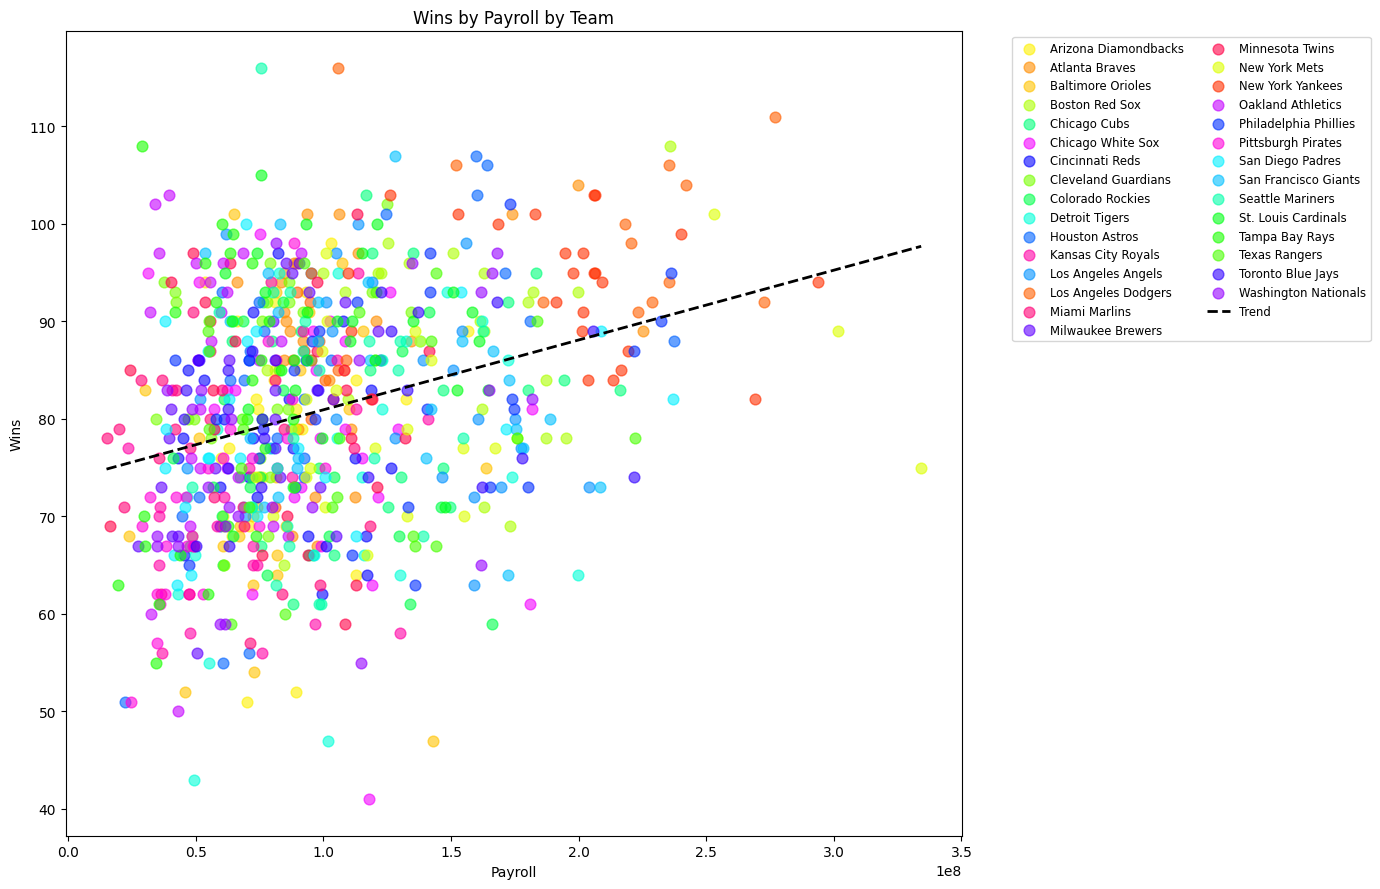

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

train = pd.read_csv('/content/MLB_train.csv')
test = pd.read_csv('/content/MLB_test.csv')

for df in (train, test):
    df['payroll_per_win'] = df['Total_Payroll'] / df['Wins']    df['log_pay'] = np.log(df['Total_Payroll'])    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

feature_cols = ['Total_Payroll', 'payroll_per_win', 'log_pay']
X_train, y_train = train[feature_cols], train['Wins']
X_test, y_test = test[feature_cols], test['Wins']

models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

results = []
model_outputs = {}

def get_bias(true_vals, preds):
    """Mean bias error = avg(predicted - actual)"""
    return np.mean(preds - true_vals)

def plot_residuals(predictions, residuals, title):
    plt.figure(figsize=(6, 4))
    plt.scatter(predictions, residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted Wins")
    plt.ylabel("Residuals")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{title.lower().replace(' ', '_')}_resid.png")
    plt.show()

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    residuals = y_test - preds

    model_outputs[name] = {
        'preds': preds,
        'resids': residuals,
        'model': model
    }

    results.append([
        name,
        r2_score(y_test, preds),
        mean_absolute_error(y_test, preds),
        np.sqrt(mean_squared_error(y_test, preds)),
        get_bias(y_test, preds)
    ])

    plot_residuals(preds, residuals, f"{name} Residuals")

# Output summary of performance
summary_df = pd.DataFrame(results, columns=['Model', 'R2', 'MAE', 'RMSE', 'MBE'])
summary_df.sort_values('R2', ascending=False, inplace=True)

print("\nTest Set Performance Summary:")
print(summary_df)
summary_df.to_csv("model_summary.csv", index=False)

# Use Random Forest model to dig a little deeper
rf = model_outputs['Random Forest']
test['Predicted'] = rf['preds']
test['Residual'] = rf['resids']

# Residual distribution plot
plt.figure(figsize=(8, 5))
sns.histplot(test['Residual'], bins=30, kde=True, color='steelblue')
plt.axvline(0, color='black', linestyle='--')
plt.title("Residuals (Actual - Predicted)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.savefig("rf_residuals_hist.png")
plt.show()

# Predicted vs Actual
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=rf['preds'], hue=test['Team'], palette='tab20', legend=False)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('Actual Wins')
plt.ylabel('Predicted Wins')
plt.title('Random Forest: Predicted vs Actual')
plt.grid(True)
plt.tight_layout()
plt.savefig("rf_pred_vs_actual.png")
plt.show()

# Teams that outperformed or underperformed the most
sorted_resid = test.sort_values('Residual')
overachievers = sorted_resid.head(5)
underachievers = sorted_resid.tail(5)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=pd.concat([overachievers, underachievers]),
    x='Residual', y='Team', hue='Year', dodge=False
)
plt.axvline(0, color='black', linestyle='--')
plt.title('Biggest Over/Under Performers (Random Forest)')
plt.xlabel('Residual')
plt.ylabel('Team')
plt.grid(True)
plt.tight_layout()
plt.savefig("over_under_teams.png")
plt.show()

# Visualize relationship between payroll and wins
combined = pd.concat([train, test])

plt.figure(figsize=(10, 6))
sns.scatterplot(data=combined, x='Total_Payroll', y='Wins')
plt.title('Payroll vs Wins')
plt.xlabel('Payroll')
plt.ylabel('Wins')
plt.grid(True)
plt.tight_layout()
plt.savefig("wins_vs_payroll.png")
plt.show()

# Correlation matrix (tiny but helpful)
plt.figure(figsize=(5, 4))
sns.heatmap(combined[['Total_Payroll', 'Wins']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Payroll-Wins Correlation")
plt.tight_layout()
plt.savefig("payroll_correlation.png")
plt.show()

# Trend line per team
plt.figure(figsize=(14, 9))
teams = combined['Team'].unique()
colors = dict(zip(teams, sns.color_palette("hsv", len(teams))))

for team, df_team in combined.groupby('Team'):
    plt.scatter(df_team['Total_Payroll'], df_team['Wins'], color=colors[team], alpha=0.6, label=team, s=60)

# Add a simple linear trend line
trend = LinearRegression()
trend.fit(combined[['Total_Payroll']], combined['Wins'])
x_range = np.linspace(combined['Total_Payroll'].min(), combined['Total_Payroll'].max(), 500).reshape(-1, 1)
y_trend = trend.predict(x_range)

plt.plot(x_range, y_trend, '--k', linewidth=2, label='Trend')

plt.title("Wins by Payroll by Team")
plt.xlabel("Payroll")
plt.ylabel("Wins")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2, fontsize='small')
plt.tight_layout()
plt.savefig("team_trend_plot.png")
plt.show()

In [ ]:
import joblib

# Save trained Random Forest model to a file
joblib.dump(model_predictions['Random Forest']['model'], 'model.pkl')

# Download to local machine
from google.colab import files
files.download('model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>